In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy
from tqdm.notebook import tqdm

import torch
import torch.distributions as dist

import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from gpytorch.utils.quadrature import GaussHermiteQuadrature1D

from pymc3.gp.util import plot_gp_dist

In [3]:
%config InlineBackend.figure_format = "retina"
sns.set()

In [4]:
# Set seed
np.random.seed(123)

# CPT fit

In [5]:
def u_pow(x, theta): return x**theta

def u_exp(x, theta): return 1 - np.exp(-theta*x)

def u_lin(x, theta): return x

def prelec(p, theta): return np.exp(-(-np.log(p))**theta)

In [6]:
def softplus(x):
    return np.log(np.exp(x) + 1)

def objective(data, u, w):
    
    pA = data.pA.values
    pB = data.pB.values

    xA0 = data.xA0.values
    xA1 = data.xA1.values

    xB0 = data.xB0.values
    xB1 = data.xB1.values

    y = data.y.values 
    
    def run(param):
        
        tau = softplus(param[0])
        theta_u = softplus(param[1])
        
        if w is not None:
            theta_w = expit(param[2])
            wpA = w(pA, theta_w)
            wpB = w(pB, theta_w)
        
        else:
            wpA = pA
            wpB = pB
        
        uxA0 = u(xA0, theta_u)
        uxA1 = u(xA1, theta_u)
        uxB0 = u(xB0, theta_u)
        uxB1 = u(xB1, theta_u)

        seuA = wpA * uxA0 + (1-wpA) * uxA1
        seuB = wpB * uxB0 + (1-wpB) * uxB1

        diff_seu = seuB - seuA

        p_choice_B = scipy.special.expit(tau*diff_seu)
        p_choice_y = p_choice_B**y * (1-p_choice_B)**(1-y)

        lls = np.log(p_choice_y + np.finfo(float).eps).sum()
        return - lls
    return run

def optimize(data, u=u_pow, w=None, seed=12345):
    np.random.seed(seed)
    if w is None:
        opt = scipy.optimize.minimize(objective(data, u, w), x0=np.ones(2))
        theta_w = None
    else:
        opt = scipy.optimize.minimize(objective(data, u, w), x0=np.ones(3))
        theta_w = expit(opt.x[2])
        
    tau = softplus(opt.x[0])
    theta_u = softplus(opt.x[1])
    return tau, theta_u, theta_w

# Artificial data

In [7]:
def generate_data(u, seed=123, n=100, tau=3.333, theta=0.5):
    
    np.random.seed(seed)

    data = pd.DataFrame(np.zeros((n*10, 6)), 
                        columns=["pA", "xA0", "xA1", "pB", "xB0", "xB1"])
    
    for opt in 'A', 'B':
        data[f'p{opt}'] = np.random.random(size=n*10) 
        a = np.random.random(size=(n*10, 2))
        a = np.sort(-a, -1)*(-1)
        for i in range(2):
            data[f'x{opt}{i}'] = a[:, i]
        
    data = data[~((data.pA >= data.pB) & (data.xA0 >= data.xB0))]
    data = data[~((data.pB >= data.pA) & (data.xB0 >= data.xA0))]
    data = data.sample(n=n, replace=False)
    
    pA = data.pA.values
    pB = data.pB.values

    xA0 = data.xA0.values
    xA1 = data.xA1.values

    xB0 = data.xB0.values
    xB1 = data.xB1.values
    
    seuA = pA * u(xA0, theta) + (1-pA) * u(xA1, theta)
    seuB = pB * u(xB0, theta) + (1-pB) * u(xB1, theta)

    diff_eu = seuB - seuA

    p_chooseB = scipy.special.expit(tau * diff_eu)
    choices = np.zeros(n, dtype=int)
    choices[:] = p_chooseB > np.random.random(size=n)
    data['y'] = choices
    data['p_CB'] = p_chooseB

    return data

# Discrepancy modeling

In [38]:
class DiscrepancyLikelihood:
    
    def __init__(self, pA, pB, belong_A0, belong_A1, belong_B0, belong_B1, tau, n_sample=20):
        
        self.pA = pA
        self.pB = pB
        self.A0 = belong_A0
        self.A1 = belong_A1
        self.B0 = belong_B0
        self.B1 = belong_B1
        self.n_x = 4*pA.size(0)
        self.n_y = belong_A0.shape[0]
        self.tau = tau

        self.quadrature = GaussHermiteQuadrature1D(n_sample)

    def expected_log_prob(self, observations, function_dist):
        
        def log_prob_lambda(function_samples): 
            # print(function_samples.shape)  20 x Nobs
            f = torch.sigmoid(function_samples)
            
            eu_A = self.pA * f[:, self.A0] + (1-self.pA) * f[:, self.A1]
            eu_B = self.pB * f[:, self.B0] + (1-self.pB) * f[:, self.B1]

            diff_eu =  eu_B - eu_A
            return dist.Bernoulli(logits=self.tau*diff_eu).log_prob(observations)
        
        log_prob = self.quadrature(log_prob_lambda, function_dist)
        return log_prob

In [39]:
class UMeanFunc(gpytorch.means.mean.Mean):
    
    def __init__(self, u, theta):
        super().__init__()
        self.u = u
        self.theta = theta
    
    def forward(self, x):
        return torch.logit(self.u(x.squeeze(-1), self.theta))        

In [40]:
class GPClassificationModel(ApproximateGP):
    def __init__(self, inducing_points, mean_function, kernel, learn_inducing_locations=False):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=learn_inducing_locations
        )
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = mean_function
        # self.covar_module = CustomKernel(gpytorch.kernels.RBFKernel())
        # self.mean_module = gpytorch.means.ConstantMean()  
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred

In [41]:
def run_inference(data, u_model, theta, tau, training_iter, learning_rate=0.05,
                  use_ratio=False, learn_inducing_locations=False,
                  n_inducing_points=50, n_sample=20):
    
    pA = data.pA.values
    pB = data.pB.values

    xA0 = data.xA0.values
    xA1 = data.xA1.values

    xB0 = data.xB0.values
    xB1 = data.xB1.values

    y = data.y.values 

    x = np.hstack((xA0, xA1, xB0, xB1))
    x_order = np.argsort(x)
    x_sorted = x[x_order]
    init_order = np.argsort(x_order)

    n_y = len(y)

    belong_A0, belong_A1, belong_B0, belong_B1  = init_order.reshape((4, n_y))
    
    train_x = torch.from_numpy(x_sorted.astype(np.float32))
    train_y = torch.from_numpy(y.astype(np.float32))
    train_pA = torch.from_numpy(pA.astype(np.float32))
    train_pB = torch.from_numpy(pB.astype(np.float32))
    
    inducing_points = torch.linspace(0, 1, n_inducing_points) 
    # torch.cat((torch.linspace(0, 0.1, 100), torch.linspace(0.15, 1, 20)))
    
    mean_function = UMeanFunc(u=u_model, theta=theta)
    
    if use_ratio:
        kernel = RatioKernel(gpytorch.kernels.RBFKernel())
    else:
        kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    model = GPClassificationModel(inducing_points=inducing_points,
                                  mean_function=mean_function, 
                                  kernel=kernel)
    likelihood = DiscrepancyLikelihood(pA=train_pA, 
                                       pB=train_pB,
                                       tau=tau, 
                                       n_sample=n_sample,
                                       belong_A0=belong_A0,
                                       belong_A1=belong_A1,
                                       belong_B0=belong_B0,
                                       belong_B1=belong_B1)

    # Find optimal model hyperparameters
    model.train()
    # likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # "Loss" for GPs - the marginal log likelihood
    # num_data refers to the number of training datapoints
    mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel())


    iterator = tqdm(range(training_iter))
    
    losses = []

    for i in iterator:
        # Zero backpropped gradients from previous iteration
        optimizer.zero_grad()
        # Get predictive output
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()

        optimizer.step()
        
        losses.append(loss.item())

        iterator.set_postfix(loss=loss.item())
    
    return model, losses

# Run

In [142]:
u_model = u_pow
tau = 100
theta = 0.5
n = 200
d = generate_data(u=u_model, tau=tau, theta=theta, n=n)
d

,pA,xA0,xA1,pB,xB0,xB1,y,p_CB
674,0.328335,0.719289,0.064078,0.767517,0.520216,0.041979,1,9.999998e-01
436,0.953818,0.425220,0.086231,0.328790,0.631256,0.287402,0,1.904348e-01
426,0.987351,0.176769,0.067219,0.096225,0.699876,0.682535,1,1.000000e+00
933,0.015745,0.820461,0.537320,0.806404,0.631259,0.112848,0,4.740453e-02
501,0.392304,0.882028,0.181892,0.871575,0.881193,0.364969,1,1.000000e+00
...,...,...,...,...,...,...,...,...
671,0.002092,0.900329,0.344484,0.573731,0.787969,0.175919,1,9.999563e-01
964,0.481115,0.972555,0.653479,0.828372,0.919383,0.213920,0,1.164722e-01
1734,0.281660,0.627913,0.518847,0.652524,0.068779,0.064148,0,1.228938e-21
180,0.562218,0.276337,0.076794,0.057695,0.922926,0.501831,1,1.000000e+00


In [143]:
opt_param = optimize(d, u=u_model, w=None)
tau_opt = opt_param[0]
theta_opt = opt_param[1]
print("tau", tau_opt, "theta_u", theta_opt)

tau 115.55567565183459 theta_u 0.45487383253618446


## Good prior

In [144]:
model, losses = run_inference(
    data=d, u_model=u_model, 
    theta=theta, tau=tau, 
    n_sample=20, 
    training_iter=500,
    learning_rate=0.1,
    learn_inducing_locations=True,
    n_inducing_points=50)

  0%|          | 0/500 [00:00<?, ?it/s]

In [145]:
test_x = torch.linspace(0, 1, 101)
f_preds = model(test_x)
pred = torch.sigmoid(f_preds.sample(torch.Size((1000,)))).numpy()

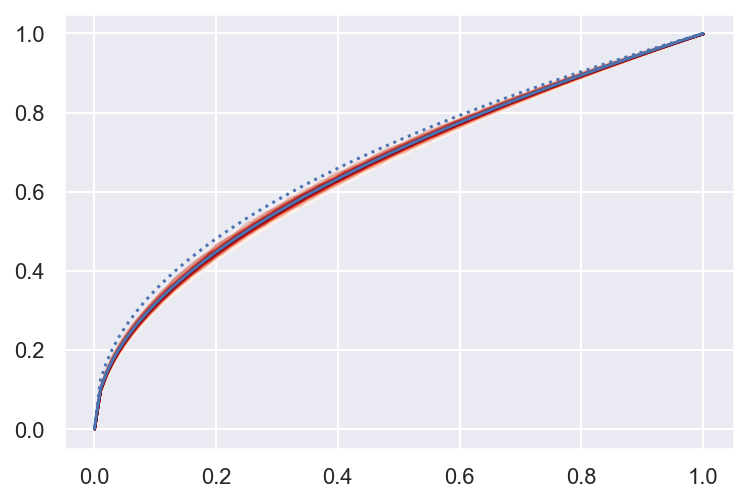

In [146]:
fig, ax = plt.subplots()
plot_gp_dist(ax, pred, test_x)
ax.plot(test_x, u_model(test_x, theta))
ax.plot(test_x, u_model(test_x, theta_opt), ls=':', color='C0')

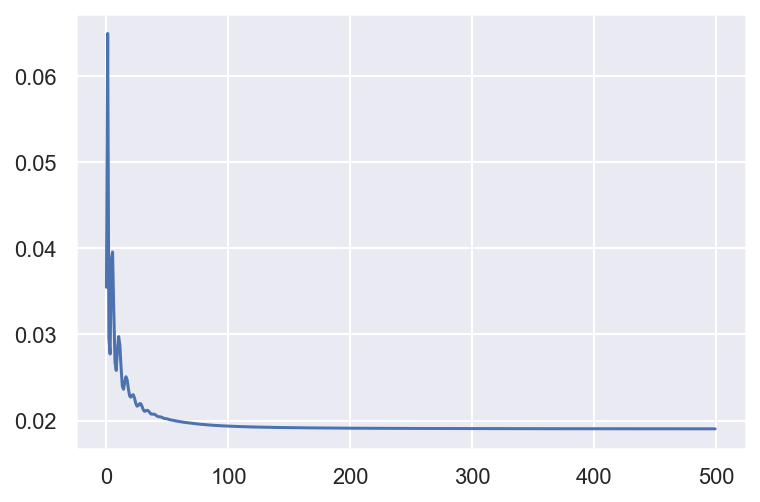

In [147]:
plt.plot(losses)

In [148]:
model.covar_module.base_kernel.lengthscale.item()

0.7392415404319763

In [149]:
model.covar_module.outputscale.item()

0.0013405689969658852

In [150]:
model.covar_module.base_kernel.lengthscale.item()

0.7392415404319763

## Wrong prior

In [157]:
model, losses = run_inference(
    data=d, u_model=u_lin, 
    theta=theta, tau=tau, 
    n_sample=20, 
    training_iter=500,
    learning_rate=0.1,  # 0.01
    learn_inducing_locations=False,
    n_inducing_points=50)

  0%|          | 0/500 [00:00<?, ?it/s]

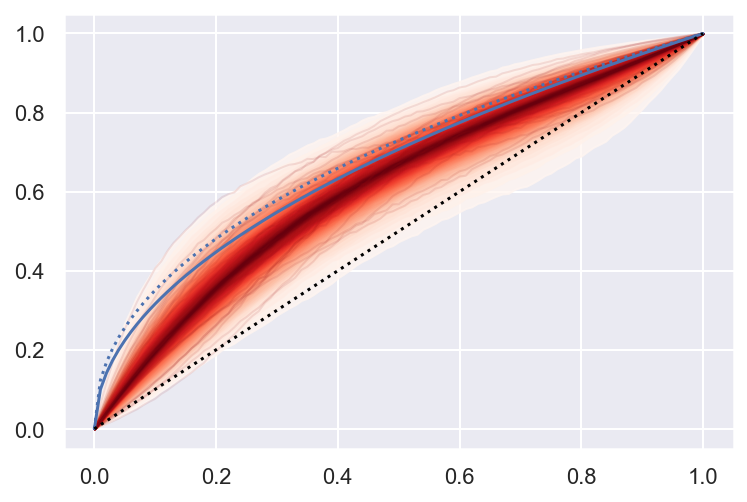

In [158]:
test_x = torch.linspace(0, 1, 101)
f_preds = model(test_x)
pred = torch.sigmoid(f_preds.sample(torch.Size((1000,)))).numpy()
fig, ax = plt.subplots()
plot_gp_dist(ax, pred, test_x)
ax.plot(test_x, u_model(test_x, theta), color='C0')
ax.plot(test_x, u_model(test_x, theta_opt), ls=':', color='C0')
ax.plot(test_x, u_lin(test_x, None), ls=':', color='black')

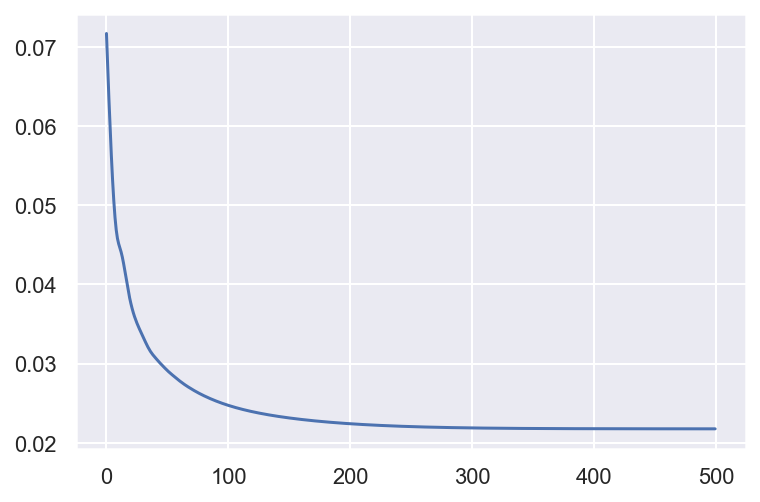

In [72]:
plt.plot(losses)

## With real data

In [126]:
df = pd.read_csv("../data/cpc2018.csv")

In [127]:
data = df[(df.LotNumB == 1) & (df.LotNumA == 1) & (df.Amb == 0) 
          & (df.Ha >= 0) & (df.Hb >= 0) & (df.La >= 0) & (df.Lb >= 0)]  # & (df.La ==0)  & (df.Lb == 0)

In [128]:
data = pd.DataFrame({
    "subject": data.SubjID,
    "pA": data.pHa.values,
    "xA0": data.Ha.values,
    "xA1": data.La.values,
    "pB": data.pHb.values,
    "xB0": data.Hb.values,
    "xB1": data.Lb.values,
    "y": data.B.values
})
max_x = np.max(np.concatenate((data.xA0, data.xA1, data.xB0, data.xB1)))
data.xA0, data.xA1, data.xB0, data.xB1 = data.xA0/max_x, data.xA1/max_x, data.xB0/max_x, data.xB1/max_x

In [129]:
data

,subject,pA,xA0,xA1,pB,xB0,xB1,y
25,10100,1.0,0.019802,0.019802,0.5,0.029703,0.009901,0
26,10100,1.0,0.019802,0.019802,0.5,0.029703,0.009901,0
27,10100,1.0,0.019802,0.019802,0.5,0.029703,0.009901,0
28,10100,1.0,0.019802,0.019802,0.5,0.029703,0.009901,0
29,10100,1.0,0.019802,0.019802,0.5,0.029703,0.009901,0
...,...,...,...,...,...,...,...,...
510395,71109,1.0,0.188119,0.188119,0.1,0.960396,0.049505,0
510396,71109,1.0,0.188119,0.188119,0.1,0.960396,0.049505,0
510397,71109,1.0,0.188119,0.188119,0.1,0.960396,0.049505,0
510398,71109,1.0,0.188119,0.188119,0.1,0.960396,0.049505,0


In [130]:
opt_param = optimize(data, u=u_model, w=None)
tau_opt = opt_param[0]
theta_opt = opt_param[1]
print("tau", tau_opt, "theta", theta_opt)

tau 26.720759439803953 theta 0.8174693045702498


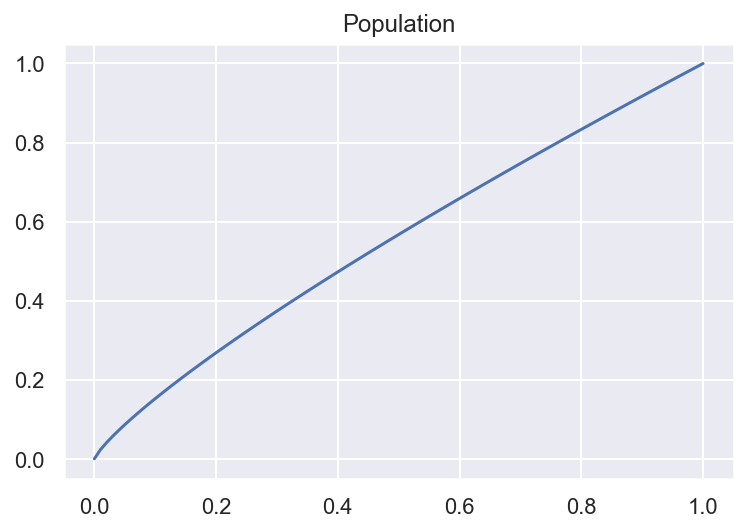

In [131]:
fig, ax = plt.subplots()
ax.set_title(f"Population")
ax.plot(test_x, u_model(test_x, theta_opt))
plt.show()

In [132]:
s = 11303
d = data[data.subject == s]

In [133]:
opt_param = optimize(d, u=u_model, w=None)
tau_opt = opt_param[0]
theta_opt = opt_param[1]
print("tau", tau_opt, "theta_u", theta_opt)

tau 669.9003783489594 theta_u 1.1510168681985715


In [140]:
model, losses = run_inference(
    data=d, u_model=u_lin, theta=theta_opt, tau=tau_opt, 
    n_sample=20, 
    training_iter=1000,
    learning_rate=0.1,
    learn_inducing_locations=False,
    n_inducing_points=50)

  0%|          | 0/1000 [00:00<?, ?it/s]

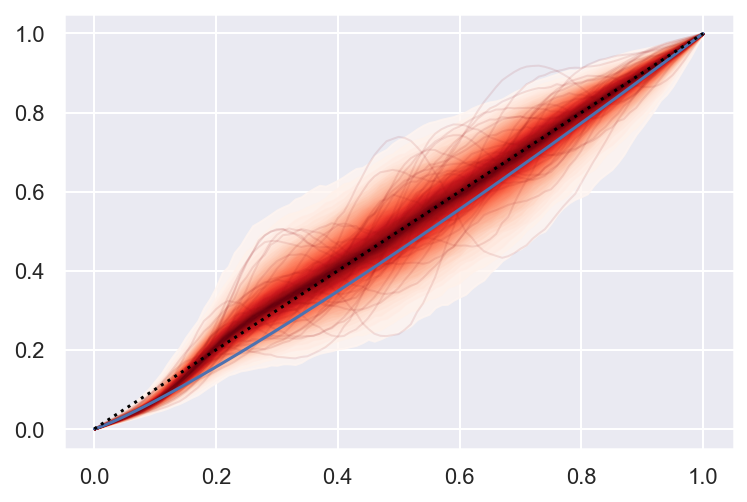

In [141]:
test_x = torch.linspace(0, 1, 101)
f_preds = model(test_x)
pred = torch.sigmoid(f_preds.sample(torch.Size((1000,)))).numpy()
fig, ax = plt.subplots()
plot_gp_dist(ax, pred, test_x)
ax.plot(test_x, u_model(test_x, theta_opt))
ax.plot((0, 1), (0, 1), color="black", ls=":")

# All subjects

In [159]:
counts = data.subject.value_counts()
subject_325 =  counts[counts == 325].index

  0%|          | 0/125 [00:00<?, ?it/s]

Subject 11303 tau=669.9003783489594 theta=1.1510168681985715


  0%|          | 0/2000 [00:00<?, ?it/s]

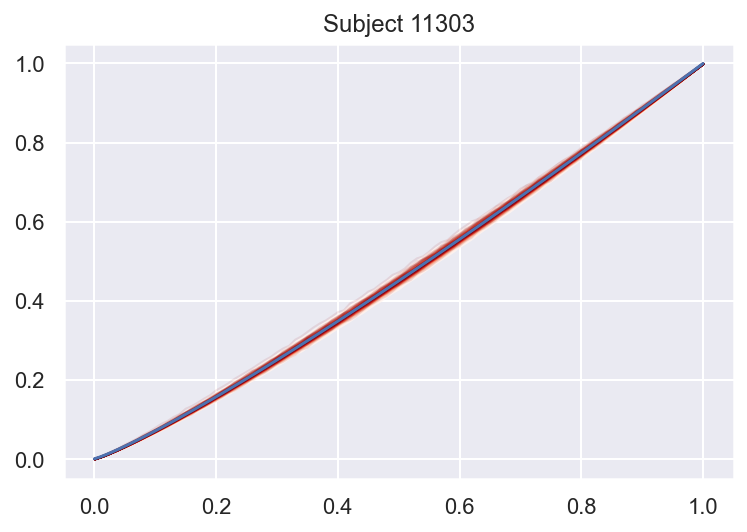

Subject 10113 tau=27.457652676296455 theta=3.093224564166293


  0%|          | 0/2000 [00:00<?, ?it/s]

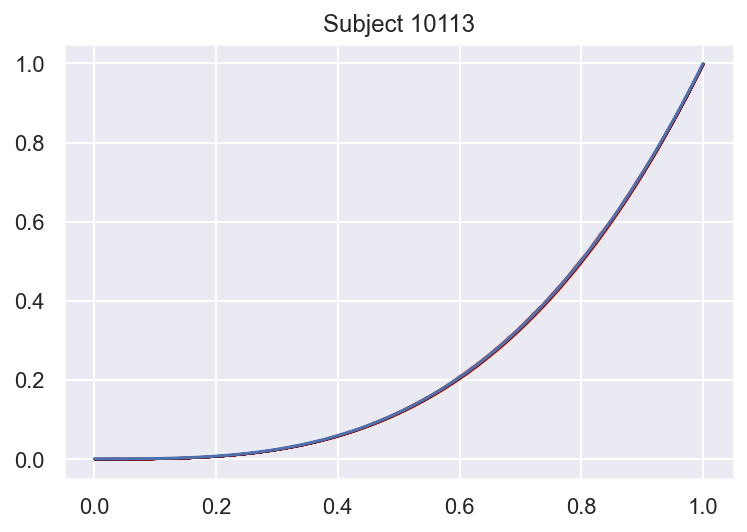

Subject 10316 tau=55.30374016002006 theta=1.32715661513436


  0%|          | 0/2000 [00:00<?, ?it/s]

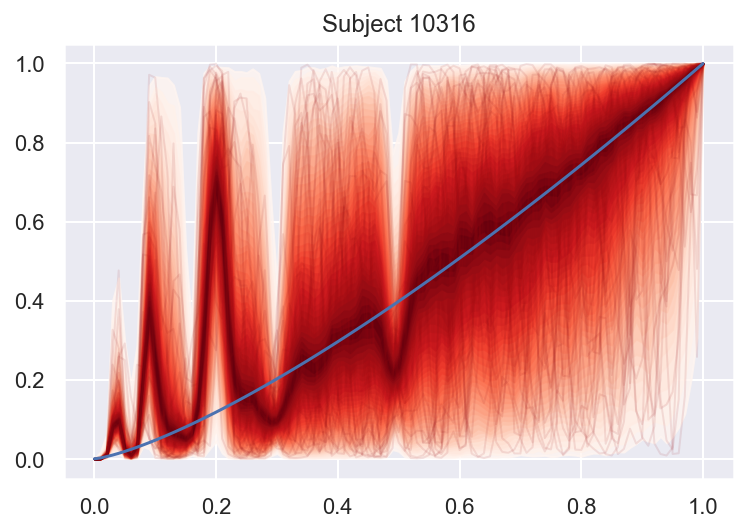

Subject 11603 tau=13.170728787717524 theta=0.49483906691992047


  0%|          | 0/2000 [00:00<?, ?it/s]

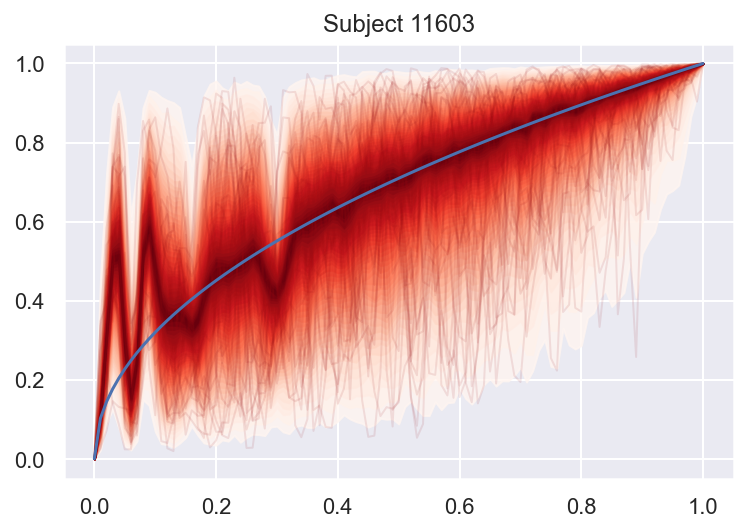

Subject 11020 tau=665.1225566742039 theta=1.143761741641188


<ipython-input-6-ec4717dd9303>:2: RuntimeWarning: overflow encountered in exp
  return np.log(np.exp(x) + 1)
<ipython-input-6-ec4717dd9303>:2: RuntimeWarning: overflow encountered in exp
  return np.log(np.exp(x) + 1)


  0%|          | 0/2000 [00:00<?, ?it/s]

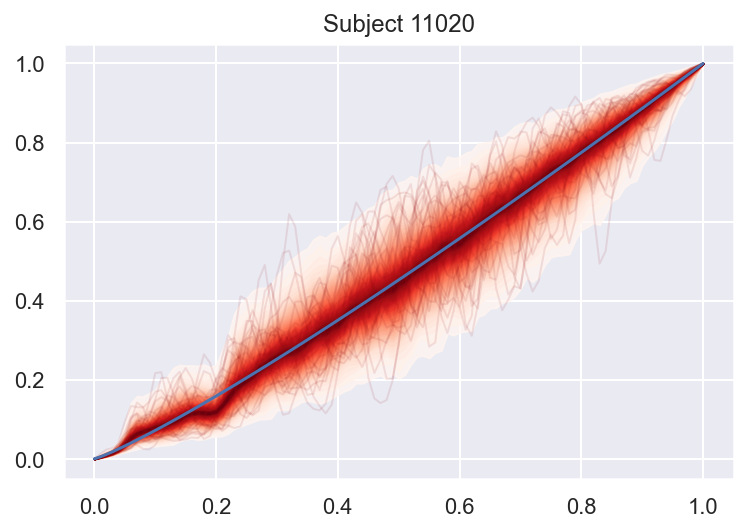

Subject 11315 tau=35.61324743968928 theta=3.4454303015011067


  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
for s in tqdm(subject_325):
    try:
        d = data[data.subject == s]
        opt_param = optimize(d, u=u_model, w=None)
        tau_opt = opt_param[0]
        theta_opt = opt_param[1]
        print(f"Subject {s} tau={tau_opt} theta={theta_opt}")

        model, losses = run_inference(
            data=d, u_model=u_model, theta=theta_opt, tau=tau_opt,
                n_sample=20, 
                training_iter=2000,
                learning_rate=0.1,
                learn_inducing_locations=False,
                n_inducing_points=50)
        test_x = torch.linspace(0, 1, 101)
        f_preds = model(test_x)
        pred = torch.sigmoid(f_preds.sample(torch.Size((1000,)))).numpy()
        fig, ax = plt.subplots()
        ax.set_title(f"Subject {s}")
        plot_gp_dist(ax, pred, test_x)
        ax.plot(test_x, u_model(test_x, theta_opt))
        plt.show()
    except Exception as e:
        print(f"Error with Subject {s}: {e}")

In [ ]:
for s in tqdm(subject_325):
    try:
        d = data[data.subject == s]
        opt_param = optimize(d, u=u_model, w=None)
        tau_opt = opt_param[0]
        theta_opt = opt_param[1]
        print(f"Subject {s} tau={tau_opt} theta={theta_opt}")

        model, losses = run_inference(
            data=d, u_model=u_lin, theta=theta_opt, tau=tau_opt, 
            n_sample=20, 
            training_iter=2000,
            learning_rate=0.1,
            learn_inducing_locations=False,
            n_inducing_points=50)
        test_x = torch.linspace(0, 1, 101)
        f_preds = model(test_x)
        pred = torch.sigmoid(f_preds.sample(torch.Size((1000,)))).numpy()
        fig, ax = plt.subplots()
        ax.set_title(f"Subject {s}")
        plot_gp_dist(ax, pred, test_x)
        ax.plot(test_x, u_lin(test_x, theta_opt), color='C2', ls=':')
        ax.plot(test_x, u_model(test_x, theta_opt), color='C0')
        plt.show()
    except Exception as e:
        print(f"Error with Subject {s}: {e}")

# Broken things

In [9]:
class RatioKernel(gpytorch.kernels.ScaleKernel):
    """
    broken!
    """
    def __call__(self, x1, x2=None, *args, **kwargs):
        if x2 is None:
            x2 = x1
        return  u(x1) * u(x2.T) * super().__call__(x1, x2, *args, **kwargs)